## install


In [ ]:
!pip install -qqq 'open_clip_torch[training]'

## test


In [7]:
import torch
import open_clip
from PIL import Image

open_clip.list_pretrained()

[('RN50', 'openai'),
 ('RN50', 'yfcc15m'),
 ('RN50', 'cc12m'),
 ('RN101', 'openai'),
 ('RN101', 'yfcc15m'),
 ('RN50x4', 'openai'),
 ('RN50x16', 'openai'),
 ('RN50x64', 'openai'),
 ('ViT-B-32', 'openai'),
 ('ViT-B-32', 'laion400m_e31'),
 ('ViT-B-32', 'laion400m_e32'),
 ('ViT-B-32', 'laion2b_e16'),
 ('ViT-B-32', 'laion2b_s34b_b79k'),
 ('ViT-B-32', 'datacomp_xl_s13b_b90k'),
 ('ViT-B-32', 'datacomp_m_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_clip_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_laion_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_image_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_text_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_basic_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_s128m_b4k'),
 ('ViT-B-32', 'datacomp_s_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_clip_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_laion_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_image_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_text_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_basic_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_s13m_b4k'),
 ('ViT-

In [ ]:
model_name = "ViT-B-32"
pretrained = "laion2b_s34b_b79k"
model, _, preprocess = open_clip.create_model_and_transforms(
    model_name, pretrained=pretrained
)
model.eval()
tokenizer = open_clip.get_tokenizer(model_name)

In [ ]:
image = preprocess(Image.open("./images/dog.jpg")).unsqueeze(0)
text = tokenizer(["a girl", "a dog", "a cat"])

with torch.no_grad(), torch.autocast("cuda"):
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

print("Label probs:", text_probs)  # prints: [[1., 0., 0.]]

Label probs: tensor([[7.6021e-04, 9.9922e-01, 1.8596e-05]])


## train


In [ ]:
import os

root = "./dataset/img"
images = os.listdir(root)
images_dict = {os.path.splitext(i)[0]: i for i in images}
len(images), images[:10]

In [ ]:
import pandas as pd

df = pd.read_excel("./dataset/feat/feat_schema.xlsx")
df.head()

,img_id,building_type,height_level,height_level_int,style,building_count,building_count_int,roof_type,scene_elements,viewpoint,notes
0,mob_001,office,high,10,Modern Office Building,single,1,unknown,trees road,eye_level,NaN
1,mob_002,office,high,10,Modern Office Building,single,1,flat,trees,eye_level,NaN
2,mob_003,office,high,10,Modern Office Building,single,1,unknown,road,aerial,NaN
3,mob_004,office,medium,4,Modern Office Building,single,1,flat,trees road,oblique,NaN
4,mob_005,office,high,10,Modern Office Building,single,1,unknown,trees road,eye_level,NaN


In [3]:
df.columns

Index(['img_id', 'building_type', 'height_level', 'height_level_int', 'style',
       'building_count', 'building_count_int', 'roof_type', 'scene_elements',
       'viewpoint', 'notes'],
      dtype='object')

In [ ]:
data = {}

columns = [
    "building_type",
    "height_level",
    "style",
    "building_count",
    "roof_type",
    "viewpoint",
]
for i, row in df.iterrows():
    title = row["building_type"].lower() + ","
    title += row["height_level"].lower() + ","
    title += row["style"].lower() + ","
    title += row["building_count"].lower() + ","
    title += (row["roof_type"].lower() + ",") if row["roof_type"] != "unknown" else ""
    title += row["viewpoint"].lower()

    data[row["img_id"]] = {
        "filepath": os.path.join(root, images_dict[row["img_id"]]),
        "title": title,
        "detailed": row.to_dict(),
    }
data

In [ ]:
pd.DataFrame(list(data.values())).to_csv('val.csv', index=False, encoding='utf-8', sep='\t')

In [ ]:
import random

keys = list(data)
random.shuffle(keys)
random.shuffle(keys)

train_num = int(0.8 * len(keys))

train_data = {k: data[k] for k in keys[:train_num]}
val_data = {k: data[k] for k in keys[train_num:]}
train_data_df = pd.DataFrame(list(train_data.values()))
val_data_df = pd.DataFrame(list(val_data.values()))
train_data_df.to_csv("train.csv", index=False, encoding="utf-8", sep="\t")
val_data_df.to_csv("val.csv", index=False, encoding="utf-8", sep="\t")

In [55]:
!python -m open_clip_train.main \
  --save-frequency 10 \
  --zeroshot-frequency 1 \
  --report-to tensorboard \
  --train-data="./train.csv"  \
  --val-data="./val.csv"  \
  --csv-img-key filepath \
  --csv-caption-key title \
  --warmup 5 \
  --batch-size=8 \
  --lr=5e-4 \
  --wd=0.01 \
  --epochs=60 \
  --workers=8 \
  --model ViT-B-16

2025-07-15 07:31:44.650927: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752564704.670730   39288 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752564704.676884   39288 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-15 07:31:44.698750: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-15,07:31:53 | INFO | Running with a single process. Device cuda.
2025-07-15,07:31:53 | INFO | Loaded ViT-B-16 model c

## Load data


Load the training results from the `results.jsonl` file into a pandas DataFrame.


In [ ]:
import pandas as pd

results_path = "./logs/2025_07_15-07_31_53-model_ViT-B-16-lr_0.0005-b_8-j_8-p_amp/checkpoints/results.jsonl"
results_df = pd.read_json(results_path, lines=True)

display(results_df.head())
display(results_df.info())

,image_to_text_mean_rank,image_to_text_median_rank,image_to_text_R@1,image_to_text_R@5,image_to_text_R@10,text_to_image_mean_rank,text_to_image_median_rank,text_to_image_R@1,text_to_image_R@5,text_to_image_R@10,clip_val_loss,epoch,num_samples
0,9.894737,10,0.052632,0.263158,0.526316,9.947368,10,0.052632,0.263158,0.526316,2.161708,1,19
1,10.000000,10,0.052632,0.263158,0.578947,10.000000,10,0.052632,0.263158,0.526316,1.926758,2,19
2,9.736842,9,0.052632,0.263158,0.578947,9.947368,10,0.052632,0.263158,0.526316,1.925190,3,19
3,9.894737,10,0.052632,0.263158,0.526316,10.000000,10,0.052632,0.263158,0.526316,1.925576,4,19
4,9.947368,10,0.052632,0.263158,0.526316,10.000000,10,0.052632,0.263158,0.526316,1.925190,5,19


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   image_to_text_mean_rank    60 non-null     float64
 1   image_to_text_median_rank  60 non-null     int64  
 2   image_to_text_R@1          60 non-null     float64
 3   image_to_text_R@5          60 non-null     float64
 4   image_to_text_R@10         60 non-null     float64
 5   text_to_image_mean_rank    60 non-null     float64
 6   text_to_image_median_rank  60 non-null     int64  
 7   text_to_image_R@1          60 non-null     float64
 8   text_to_image_R@5          60 non-null     float64
 9   text_to_image_R@10         60 non-null     float64
 10  clip_val_loss              60 non-null     float64
 11  epoch                      60 non-null     int64  
 12  num_samples                60 non-null     int64  
dtypes: float64(9), int64(4)
memory usage: 6.2 KB


None

## Visualize training loss


Plot the training loss over epochs.


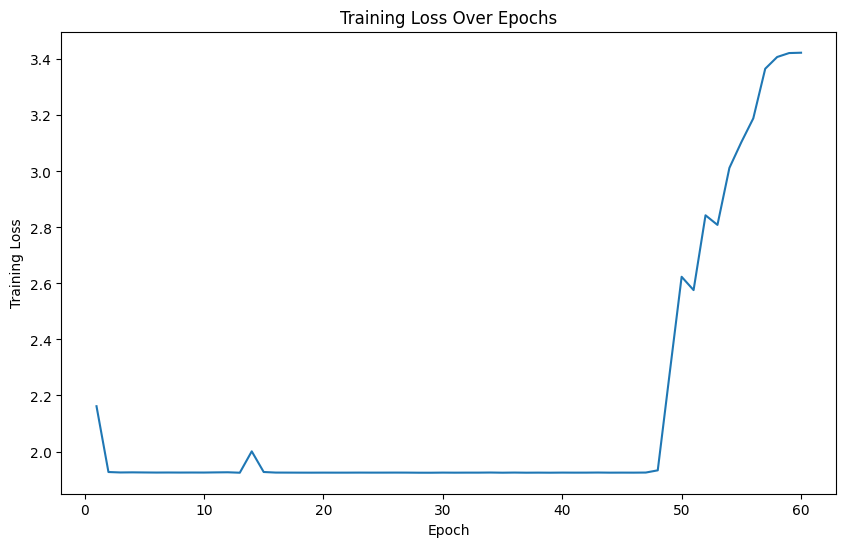

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x="epoch", y="clip_val_loss")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.show()

## Visualize validation metrics

Plot the validation metrics (e.g., R@1, R@5, R@10) over epochs.


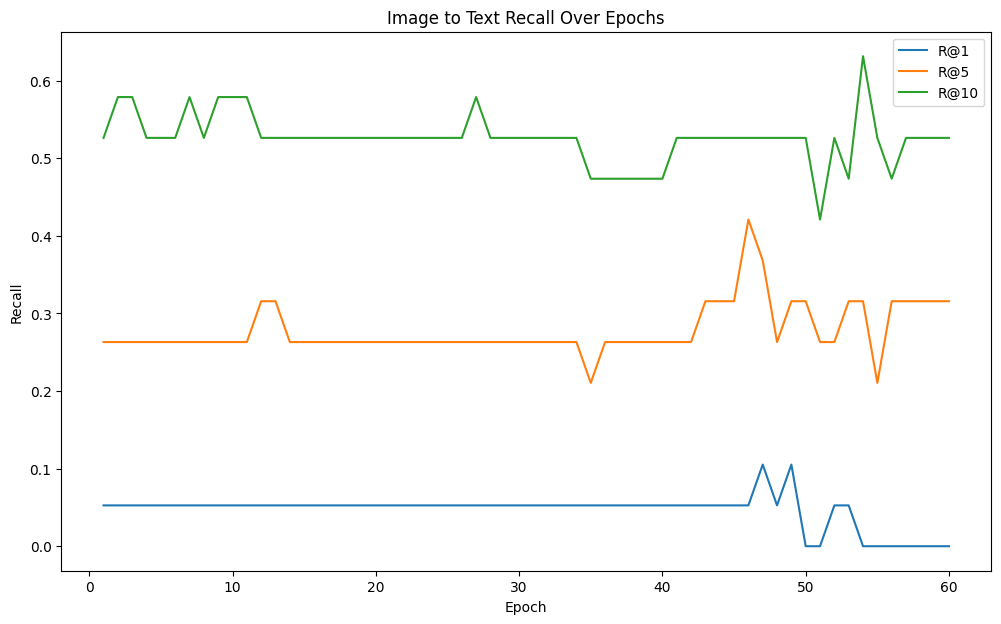

In [ ]:
plt.figure(figsize=(12, 7))
sns.lineplot(data=results_df, x="epoch", y="image_to_text_R@1", label="R@1")
sns.lineplot(data=results_df, x="epoch", y="image_to_text_R@5", label="R@5")
sns.lineplot(data=results_df, x="epoch", y="image_to_text_R@10", label="R@10")
plt.title("Image to Text Recall Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.legend()
plt.show()

**Reasoning**:
Plot the text to image recall metrics over epochs using seaborn.


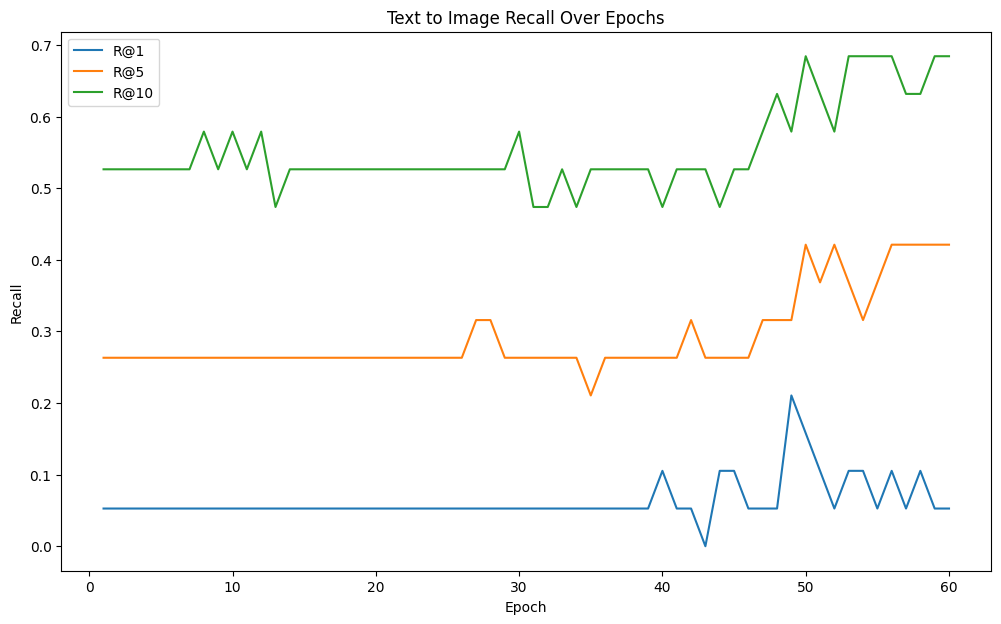

In [ ]:
plt.figure(figsize=(12, 7))
sns.lineplot(data=results_df, x="epoch", y="text_to_image_R@1", label="R@1")
sns.lineplot(data=results_df, x="epoch", y="text_to_image_R@5", label="R@5")
sns.lineplot(data=results_df, x="epoch", y="text_to_image_R@10", label="R@10")
plt.title("Text to Image Recall Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.legend()
plt.show()